# 1) Performance-Parameters Tradeoff

In [1]:
import numpy as np
import pandas as pd
from analysis_functions import Analysis
import matplotlib.pyplot as plt

In this notebook, we want to study the performance-parameters tradeoff of some different architectures for the CartPole Environment.

In theory, we want the performance to be as high as possible, and the number of parameters to be as low as possible, since this will make the training faster due to the lower number of partial derivatives we need to compute. We will compare this tradeoff for the following architectures:

- Skolik
- UQC
- Lockwood
- Multi-Qubit UQC (2 and 4 qubits)

But first, we will try to perform a hyperparameter search using optuna to find the optimal hyperparameters for each architecture.

**IMPORTANT** - So far we have only performed the hyperparameters search for the single-qubit UQC architecture. I would also like to do it for the 2-qubit UQC and 4-qubit UQC to have a better comparison between the optimal hyperparameters for each possible architecture.

In [2]:
# Data for the single qubit UQC
singlequbit_uqc_path = "../../results/continuous/uqc/globalskolik_outscaling/XZ_obs/uqc_optuna_best_hyper"

#Data for the Skolik Architecture
skolik_path = "../../results/continuous/skolik_arch/schuld_datareup/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper_mse"

#Data for the 2 qubit UQC Full Encoding
uqc2qubit_fullencoding_path = "../../results/continuous/uqc/globalskolik_outscaling/XZ_obs/multi_qubit_full_encoding_final/2qubits_3layers"

#Data for the 4 qubit UQC Full Encoding
uqc4qubit_fullencoding_path = "../../results/continuous/uqc/globalskolik_outscaling/XZ_obs/multi_qubit_full_encoding_final/4qubits_5layers"

#Data for the 2 qubit UQC Partial Encoding
uqc2qubit_partialencoding_path = "../../results/continuous/uqc/globalskolik_outscaling/XZ_obs/multi_qubit_final/2qubits_4layers"

#Data for the 4 qubit UQC Partial Encoding
uqc4qubit_partialencoding_path = "../../results/continuous/uqc/globalskolik_outscaling/XZ_obs/multi_qubit_final/4qubits_5layers"

In [3]:
singlequbit_uqc_analysis = Analysis(singlequbit_uqc_path)
skolik_analysis = Analysis(skolik_path)

uqc2qubit_fullencoding_analysis = Analysis(uqc2qubit_fullencoding_path)
uqc4qubit_fullencoding_analysis = Analysis(uqc4qubit_fullencoding_path)

uqc2qubit_partialencoding_analysis = Analysis(uqc2qubit_partialencoding_path)
uqc4qubit_partialencoding_analysis = Analysis(uqc4qubit_partialencoding_path)

Since I want to analyse the parameters-performance tradeoff, I first need to define a performance measure. In this scenario, I chose the area under the curve (AUC) of the return per episode averaged over the 10 agents. To normalize it between 0 and 1, the actual performance measure will be given by $AUC/maximum\_performance\_area$, where $maximum\_performance\_area = maximum\_reward*number\_of\_episodes$.

In [4]:
def calculate_mean_return(results, number_of_episodes):
    results = [r[:number_of_episodes] for r in results]
    results_mean = np.mean(results, axis=0)
    return results_mean

In [5]:
def performance(results, maximum_reward, number_of_episodes):
    results_mean = calculate_mean_return(results, number_of_episodes)
    area_under_curve = np.trapz(results_mean)
    maximum_performance_area = maximum_reward * number_of_episodes
    performance = area_under_curve / maximum_performance_area
    return performance

Since some of these models were only run for $1000$ episodes, that's the number of episodes I will use. Moreover, since the environment is "CartPole-v0", the maximum reward is $200$.

Thus, I will now calculate the performance of each model.

In [6]:
single_qubit_uqc_return = singlequbit_uqc_analysis.get_rewards()
# I have to filter out some returns of agents that lasted only 500 episodes
single_qubit_uqc_return = [sublist for sublist in single_qubit_uqc_return if len(sublist) != 500]
single_qubit_uqc_performance = performance(single_qubit_uqc_return, 200, 1000)

skolik_return = skolik_analysis.get_rewards()
skolik_performance = performance(skolik_return, 200, 1000)

uqc2qubit_fullencoding_return = uqc2qubit_fullencoding_analysis.get_rewards()
uqc2qubit_fullencoding_performance = performance(uqc2qubit_fullencoding_return, 200, 1000)

uqc4qubit_fullencoding_return = uqc4qubit_fullencoding_analysis.get_rewards()
uqc4qubit_fullencoding_performance = performance(uqc4qubit_fullencoding_return, 200, 1000)

uqc2qubit_partialencoding_return = uqc2qubit_partialencoding_analysis.get_rewards()
uqc2qubit_partialencoding_performance = performance(uqc2qubit_partialencoding_return, 200, 1000)

uqc4qubit_partialencoding_return = uqc4qubit_partialencoding_analysis.get_rewards()
uqc4qubit_partialencoding_performance = performance(uqc4qubit_partialencoding_return, 200, 1000)

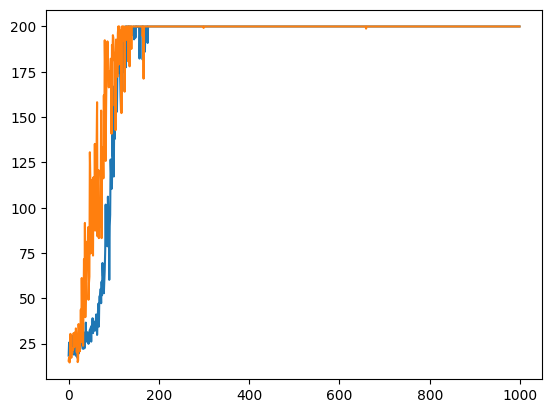

In [9]:
plt.plot(calculate_mean_return(single_qubit_uqc_return, 1000), label="Single Qubit UQC")
plt.plot(calculate_mean_return(uqc2qubit_fullencoding_return, 1000), label="2 Qubit UQC Full Encoding")

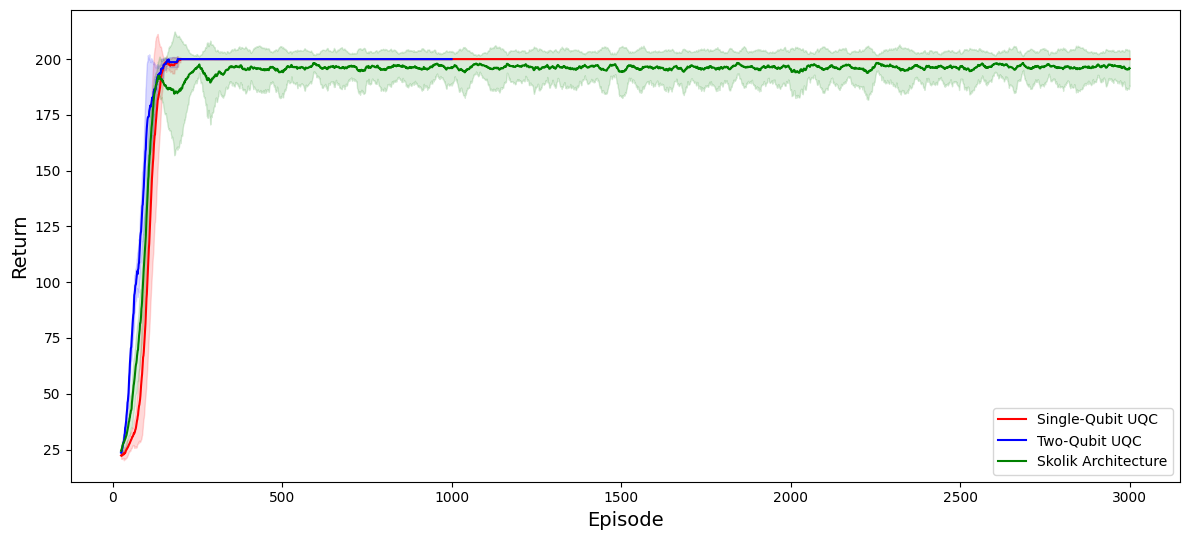

In [16]:
moving_average_single_qubit_uqc = singlequbit_uqc_analysis.get_moving_average(25)
moving_average_uqc2qubit_fullencoding = uqc2qubit_fullencoding_analysis.get_moving_average(25)
moving_average_skolik = skolik_analysis.get_moving_average(25)

moving_average_single_qubit_uqc = [sublist for sublist in moving_average_single_qubit_uqc if len(sublist) != 500]

means_single_qubit_uqc = np.mean(moving_average_single_qubit_uqc, axis=0)
means_uqc2qubit_fullencoding = np.mean(moving_average_uqc2qubit_fullencoding, axis=0)
means_skolik = np.mean(moving_average_skolik, axis=0)
stds_single_qubit_uqc = np.std(moving_average_single_qubit_uqc, axis=0)
stds_uqc2qubit_fullencoding = np.std(moving_average_uqc2qubit_fullencoding, axis=0)
stds_skolik = np.std(moving_average_skolik, axis=0)

fig, axs = plt.subplots(1, 1, tight_layout = True, figsize=(12, 5.5), sharey = True)
axs.plot(means_single_qubit_uqc, color='red', linewidth=1.5, label='Single-Qubit UQC')
axs.plot(means_uqc2qubit_fullencoding, color='blue', linewidth=1.5, label='Two-Qubit UQC')
axs.plot(means_skolik, color='green', linewidth=1.5, label='Skolik Architecture')

axs.fill_between(range(len(means_single_qubit_uqc)), means_single_qubit_uqc-stds_single_qubit_uqc, means_single_qubit_uqc+stds_single_qubit_uqc, color='red', alpha=0.15)
axs.fill_between(range(len(means_uqc2qubit_fullencoding)), means_uqc2qubit_fullencoding-stds_uqc2qubit_fullencoding, means_uqc2qubit_fullencoding+stds_uqc2qubit_fullencoding, color='blue', alpha=0.15)
axs.fill_between(range(len(means_skolik)), means_skolik-stds_skolik, means_skolik+stds_skolik, color='green', alpha=0.15)

axs.set_xlabel('Episode', fontsize=14)
axs.set_ylabel('Return', fontsize=14)
axs.legend()

# show the plot
plt.show()

In [7]:
print("Single Qubit UQC Performance: ", single_qubit_uqc_performance)
print("Skolik Performance: ", skolik_performance)
print("2 Qubit UQC Full Encoding Performance: ", uqc2qubit_fullencoding_performance)
print("4 Qubit UQC Full Encoding Performance: ", uqc4qubit_fullencoding_performance)
print("2 Qubit UQC Partial Encoding Performance: ", uqc2qubit_partialencoding_performance)
print("4 Qubit UQC Partial Encoding Performance: ", uqc4qubit_partialencoding_performance)

Single Qubit UQC Performance:  0.9173405
Skolik Performance:  0.90873725
2 Qubit UQC Full Encoding Performance:  0.941598
4 Qubit UQC Full Encoding Performance:  0.9082589999999999
2 Qubit UQC Partial Encoding Performance:  0.9244979999999999
4 Qubit UQC Partial Encoding Performance:  0.8993289999999999


Now that I have the performance of each agent defined, I want to know the number of parameters each of these models have and also the number of qubits, circuit depth and circuit measurements.

First, let's get the number of parameters.

In [9]:
single_qubit_uqc_parameters = singlequbit_uqc_analysis.get_final_weights()
single_qubit_uqc_parameters = single_qubit_uqc_parameters[0]

skolik_parameters = skolik_analysis.get_final_weights()
skolik_parameters = skolik_parameters[0]

uqc2qubit_fullencoding_parameters = uqc2qubit_fullencoding_analysis.get_final_weights()
uqc2qubit_fullencoding_parameters = uqc2qubit_fullencoding_parameters[0]
uqc4qubit_fullencoding_parameters = uqc4qubit_fullencoding_analysis.get_final_weights()
uqc4qubit_fullencoding_parameters = uqc4qubit_fullencoding_parameters[0]

uqc2qubit_partialencoding_parameters = uqc2qubit_partialencoding_analysis.get_final_weights()
uqc2qubit_partialencoding_parameters = uqc2qubit_partialencoding_parameters[0]
uqc4qubit_partialencoding_parameters = uqc4qubit_partialencoding_analysis.get_final_weights()
uqc4qubit_partialencoding_parameters = uqc4qubit_partialencoding_parameters[0]

In [10]:
def get_size(arrays):
    size = 0
    for array in arrays:
        size += array.size
    return size

In [11]:
single_qubit_uqc_parameters_size = get_size(single_qubit_uqc_parameters)

skolik_parameters_size = get_size(skolik_parameters)

uqc2qubit_fullencoding_parameters_size = get_size(uqc2qubit_fullencoding_parameters)
uqc4qubit_fullencoding_parameters_size = get_size(uqc4qubit_fullencoding_parameters)

uqc2qubit_partialencoding_parameters_size = get_size(uqc2qubit_partialencoding_parameters)
uqc4qubit_partialencoding_parameters_size = get_size(uqc4qubit_partialencoding_parameters)

In [12]:
print("Single Qubit UQC Parameters Size: ", single_qubit_uqc_parameters_size)
print("Skolik Parameters Size: ", skolik_parameters_size)
print("2 Qubit UQC Full Encoding Parameters Size: ", uqc2qubit_fullencoding_parameters_size)
print("4 Qubit UQC Full Encoding Parameters Size: ", uqc4qubit_fullencoding_parameters_size)
print("2 Qubit UQC Partial Encoding Parameters Size: ", uqc2qubit_partialencoding_parameters_size)
print("4 Qubit UQC Partial Encoding Parameters Size: ", uqc4qubit_partialencoding_parameters_size)


Single Qubit UQC Parameters Size:  32
Skolik Parameters Size:  70
2 Qubit UQC Full Encoding Parameters Size:  37
4 Qubit UQC Full Encoding Parameters Size:  121
2 Qubit UQC Partial Encoding Parameters Size:  49
4 Qubit UQC Partial Encoding Parameters Size:  121


Some of the partial encoding models have more parameters because the number of layers is higher. It might be reasonable to always compare models with the same number of layers so that the comparison is fairer.

Now, we will define how good a model is by how much performance was generated per parameter. This will be given by the performance divided by the number of parameters.

In [13]:
single_qubit_uqc_performance_per_parameter = single_qubit_uqc_performance / single_qubit_uqc_parameters_size * 100

skolik_performance_per_parameter = skolik_performance / skolik_parameters_size * 100

uqc2qubit_fullencoding_performance_per_parameter = uqc2qubit_fullencoding_performance / uqc2qubit_fullencoding_parameters_size * 100
uqc4qubit_fullencoding_performance_per_parameter = uqc4qubit_fullencoding_performance / uqc4qubit_fullencoding_parameters_size * 100

uqc2qubit_partialencoding_performance_per_parameter = uqc2qubit_partialencoding_performance / uqc2qubit_partialencoding_parameters_size * 100
uqc4qubit_partialencoding_performance_per_parameter = uqc4qubit_partialencoding_performance / uqc4qubit_partialencoding_parameters_size * 100

In [14]:
print("Single Qubit UQC Performance per Parameter: ", single_qubit_uqc_performance_per_parameter)
print("Skolik Performance per Parameter: ", skolik_performance_per_parameter)
print("2 Qubit UQC Full Encoding Performance per Parameter: ", uqc2qubit_fullencoding_performance_per_parameter)
print("4 Qubit UQC Full Encoding Performance per Parameter: ", uqc4qubit_fullencoding_performance_per_parameter)
print("2 Qubit UQC Partial Encoding Performance per Parameter: ", uqc2qubit_partialencoding_performance_per_parameter)
print("4 Qubit UQC Partial Encoding Performance per Parameter: ", uqc4qubit_partialencoding_performance_per_parameter)

Single Qubit UQC Performance per Parameter:  2.8666890625
Skolik Performance per Parameter:  1.2981960714285714
2 Qubit UQC Full Encoding Performance per Parameter:  2.5448594594594596
4 Qubit UQC Full Encoding Performance per Parameter:  0.7506272727272727
2 Qubit UQC Partial Encoding Performance per Parameter:  1.886730612244898
4 Qubit UQC Partial Encoding Performance per Parameter:  0.7432471074380165


In terms of the performance-parameters tradeoff, it seems like the single-qubit UQC is the best model, since each parameter generates 2.86% of the normalized area under the curve. However, the single-qubit UQC needs to be measured twice because the observables are applied on the same qubit. So, in terms of circuit measurements:

In [15]:
print("Single Qubit UQC Measurements: ", 2)
print("Skolik Measurements: ", 1)
print("2 Qubit UQC Full Encoding Measurements: ", 1)
print("4 Qubit UQC Full Encoding Measurements: ", 1)
print("2 Qubit UQC Partial Encoding Measurements: ", 1)
print("4 Qubit UQC Partial Encoding Measurements: ", 1)

Single Qubit UQC Measurements:  2
Skolik Measurements:  1
2 Qubit UQC Full Encoding Measurements:  1
4 Qubit UQC Full Encoding Measurements:  1
2 Qubit UQC Partial Encoding Measurements:  1
4 Qubit UQC Partial Encoding Measurements:  1


Now let's see in terms of circuit depth:

In [16]:
import sys
sys.path.append('../')

from vqc.vqc_circuits import UQC, SkolikSchuld

In [17]:
single_qubit_uqc_circuit = UQC(1, 5)
skolik_circuit = SkolikSchuld(4, 5)

uqc2qubit_fullencoding_circuit = UQC(2, 3)
uqc4qubit_fullencoding_circuit = UQC(4, 5)

uqc2qubit_partialencoding_circuit = UQC(2, 4)
uqc4qubit_partialencoding_circuit = UQC(4, 5)